In [40]:
import pandas as pd
import numpy as np
from datetime import datetime

# Summary 

This notebook is all about getting panel data sets that we can take to R for some fancier panel data tricks

In [2]:
d = pd.read_csv("211210cleaned_movie_ratings.csv")

/Users/jordanlong/.pyenv/versions/3.8.5/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
d.drop(columns="Unnamed: 0", inplace=True)

In [8]:
d.head(1)

,user,movie,rating,date,userdate,year,month,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,ur4592644,tt0120884,10,2005-01-16,ur459264416 January 2005,2005,1,tt0120884,movie,When the Light Comes,When the Light Comes,0,1998,\N,115,"Adventure,Drama,Romance"


In [9]:
d.shape

(3444441, 16)

In [5]:
movie_data = pd.read_csv("211210movie_info.csv")

/Users/jordanlong/.pyenv/versions/3.8.5/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
movie_data.drop(columns="Unnamed: 0", inplace=True)

In [7]:
movie_data.shape

(136285, 11)

In [10]:
movie_data.head(1)

,averageReview,primaryTitle,startYear,genres,runtimeMinutes,numReviews,tconst,averageRating,numVotes,diffRating,ratioVotes
0,8.666667,The Story of the Kelly Gang,1906,"Action,Adventure,Biography",70,6,tt0000574,6.1,737,-2.566667,122.833333


In [11]:
d["date"] = pd.to_datetime(d["date"])

We want the release dates of movies, and to do this we're going to assume that the first review falls around the release of a movie. This is more likely to hold true for movies with more reviews, so we'll filter our data to ensure at least 100 reviews. This just has the effect of reducing the external validity of our analysis.

In [15]:
movie_data["numReviews"].describe()

count    136285.000000
mean         25.246197
std         126.639243
min           1.000000
25%           1.000000
50%           4.000000
75%          12.000000
max       10534.000000
Name: numReviews, dtype: float64

Let's exclude movies with less than 100 reviews

<AxesSubplot:ylabel='Frequency'>

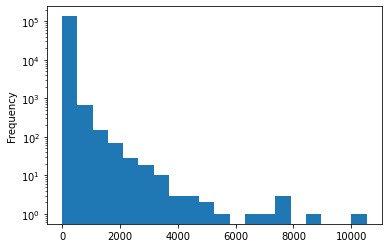

In [19]:
movie_data["numReviews"].plot(kind="hist", logy=True, bins=20)

Get first review date info

In [12]:
movie_data = movie_data.merge(d.groupby("movie")["date"].min(), left_on="tconst", right_on="movie").rename(columns={"date": "first_review"})

In [50]:
movie_data.head(1)

,averageReview,primaryTitle,startYear,genres,runtimeMinutes,numReviews,tconst,averageRating,numVotes,diffRating,ratioVotes,first_review
0,8.666667,The Story of the Kelly Gang,1906,"Action,Adventure,Biography",70,6,tt0000574,6.1,737,-2.566667,122.833333,2001-07-07


Are ratings changing over time? It looks like they decreased a bit after 2008

<AxesSubplot:xlabel='date'>

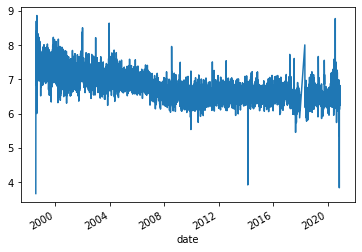

In [21]:
d.groupby("date")["rating"].mean().plot()

Are there trends in when movies are released? Lots after the artefact in 2018, and a bump in 2005,2006?

<AxesSubplot:xlabel='first_review'>

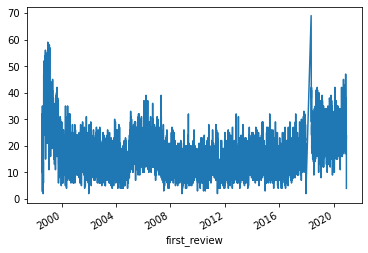

In [24]:
movie_data.groupby("first_review")["tconst"].count().plot()

In [26]:
movie_data = movie_data[movie_data["startYear"] != "\\N"]
movie_data["startYear"] = movie_data["startYear"].astype(int)

<ipython-input-26-4090c01f62d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data["startYear"] = movie_data["startYear"].astype(int)


In [51]:
d = d[d["startYear"] != "\\N"]
d["startYear"] = d["startYear"].astype(int)

<ipython-input-51-03088b3ea76b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["startYear"] = d["startYear"].astype(int)


2005-2006 bump goes away if we filter on start year

<AxesSubplot:xlabel='first_review'>

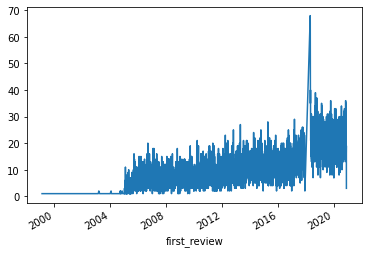

In [29]:
movie_data[movie_data["startYear"] >= 2005].groupby("first_review")["tconst"].count().plot()

Let's exclude May 2018 movies

In [35]:
movie_data[movie_data["startYear"] >= 2005].groupby("first_review")["tconst"].count().sort_values().tail(20)

first_review
2020-07-26    34
2019-03-01    34
2019-02-22    35
2018-10-19    35
2018-05-06    35
2020-11-22    35
2018-05-11    36
2018-05-07    36
2018-05-05    36
2020-11-13    36
2019-10-18    36
2018-10-12    37
2018-09-22    37
2018-10-20    37
2018-09-14    39
2018-05-08    40
2018-05-03    49
2018-05-04    58
2018-05-02    65
2018-05-01    68
Name: tconst, dtype: int64

Let's also exclude pre-2005 info

<AxesSubplot:xlabel='date'>

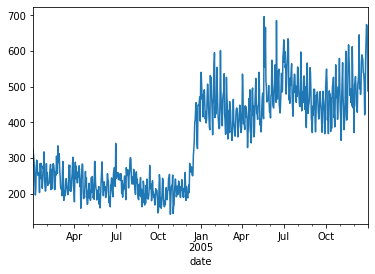

In [49]:
d[(d["date"] > datetime(2004,1,1)) & (d["date"] < datetime(2006,1,1))].groupby("date")["rating"].count().plot()

<AxesSubplot:xlabel='startYear'>

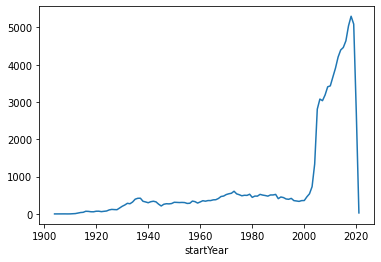

In [31]:
movie_data[movie_data["first_review"].dt.year >= 2005].groupby("startYear")["tconst"].count().plot()

getting rid of May data

In [45]:
movie_data = movie_data[(movie_data["first_review"] >= datetime(2018,6,1)) | (movie_data["first_review"] < datetime(2018,1,1))]

getting rid of pre-2005 movies

In [52]:
movie_data = movie_data[movie_data["startYear"] >= 2005]

In [54]:
movie_data = movie_data[movie_data["first_review"] >= datetime(2005,1,1)]

In [56]:
movie_data.shape

(61498, 12)

<AxesSubplot:ylabel='Frequency'>

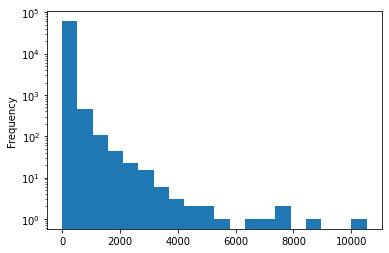

In [57]:
movie_data["numReviews"].plot(kind="hist", logy=True, bins=20)

In [58]:
movie_data[movie_data["numReviews"] >= 100]

,averageReview,primaryTitle,startYear,genres,runtimeMinutes,numReviews,tconst,averageRating,numVotes,diffRating,ratioVotes,first_review
44732,6.075258,Fantastic Four,2005,"Action,Adventure,Fantasy",106,970,tt0120667,5.7,320223,-0.375258,330.126804,2005-06-23
44906,7.508911,Corpse Bride,2005,"Animation,Drama,Family",77,505,tt0121164,7.3,258690,-0.208911,512.257426,2005-08-02
45005,7.209377,Star Wars: Episode III - Revenge of the Sith,2005,"Action,Adventure,Fantasy",140,3434,tt0121766,7.5,742810,0.290623,216.310425,2005-05-04
54545,7.412621,The Bank Job,2008,"Crime,Drama,Thriller",111,206,tt0200465,7.2,178090,-0.212621,864.514563,2008-02-11
55238,6.838735,Children of Men,2006,"Action,Drama,Sci-Fi",109,1296,tt0206634,7.9,482291,1.061265,372.138117,2006-09-02
...,...,...,...,...,...,...,...,...,...,...,...,...
136198,4.686667,Holidate,2020,"Comedy,Romance",104,300,tt9866072,6.1,54537,1.413333,181.790000,2020-10-28
136202,9.350299,Paranormal Investigation,2018,"Horror,Thriller",92,334,tt9866700,3.7,1601,-5.650299,4.793413,2019-03-03
136216,6.625000,Malang,2020,"Action,Crime,Drama",135,264,tt9877170,6.5,9750,-0.125000,36.931818,2020-02-07
136251,3.702073,Coffee & Kareem,2020,"Action,Comedy,Crime",88,386,tt9898858,5.1,12943,1.397927,33.531088,2020-04-03


Idea: capture standard deviation of movie ratings as "polarizingness score"

In [59]:
clean_movies = movie_data[movie_data["numReviews"] >= 100]

In [60]:
clean_movies

,averageReview,primaryTitle,startYear,genres,runtimeMinutes,numReviews,tconst,averageRating,numVotes,diffRating,ratioVotes,first_review
44732,6.075258,Fantastic Four,2005,"Action,Adventure,Fantasy",106,970,tt0120667,5.7,320223,-0.375258,330.126804,2005-06-23
44906,7.508911,Corpse Bride,2005,"Animation,Drama,Family",77,505,tt0121164,7.3,258690,-0.208911,512.257426,2005-08-02
45005,7.209377,Star Wars: Episode III - Revenge of the Sith,2005,"Action,Adventure,Fantasy",140,3434,tt0121766,7.5,742810,0.290623,216.310425,2005-05-04
54545,7.412621,The Bank Job,2008,"Crime,Drama,Thriller",111,206,tt0200465,7.2,178090,-0.212621,864.514563,2008-02-11
55238,6.838735,Children of Men,2006,"Action,Drama,Sci-Fi",109,1296,tt0206634,7.9,482291,1.061265,372.138117,2006-09-02
...,...,...,...,...,...,...,...,...,...,...,...,...
136198,4.686667,Holidate,2020,"Comedy,Romance",104,300,tt9866072,6.1,54537,1.413333,181.790000,2020-10-28
136202,9.350299,Paranormal Investigation,2018,"Horror,Thriller",92,334,tt9866700,3.7,1601,-5.650299,4.793413,2019-03-03
136216,6.625000,Malang,2020,"Action,Crime,Drama",135,264,tt9877170,6.5,9750,-0.125000,36.931818,2020-02-07
136251,3.702073,Coffee & Kareem,2020,"Action,Comedy,Crime",88,386,tt9898858,5.1,12943,1.397927,33.531088,2020-04-03


In [62]:
clean_data = d[d["movie"].isin(clean_movies["tconst"])]

In [63]:
clean_data

,user,movie,rating,date,userdate,year,month,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
17247,ur1529007,tt0357277,3,2005-01-16,ur152900716 January 2005,2005,1,tt0357277,movie,Elektra,Elektra,0,2005,\N,97,"Action,Adventure,Crime"
17248,ur2705247,tt0357277,10,2005-01-16,ur270524716 January 2005,2005,1,tt0357277,movie,Elektra,Elektra,0,2005,\N,97,"Action,Adventure,Crime"
17249,ur1976369,tt0357277,5,2005-01-16,ur197636916 January 2005,2005,1,tt0357277,movie,Elektra,Elektra,0,2005,\N,97,"Action,Adventure,Crime"
17250,ur3198732,tt0357277,10,2005-01-16,ur319873216 January 2005,2005,1,tt0357277,movie,Elektra,Elektra,0,2005,\N,97,"Action,Adventure,Crime"
17251,ur4571533,tt0357277,10,2005-01-16,ur457153316 January 2005,2005,1,tt0357277,movie,Elektra,Elektra,0,2005,\N,97,"Action,Adventure,Crime"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440484,ur113716864,tt10530176,3,2020-12-02,ur1137168642 December 2020,2020,12,tt10530176,movie,The Call,Kol,0,2020,\N,112,"Crime,Horror,Mystery"
3440485,ur4954395,tt10530176,6,2020-12-02,ur49543952 December 2020,2020,12,tt10530176,movie,The Call,Kol,0,2020,\N,112,"Crime,Horror,Mystery"
3440486,ur105683408,tt10530176,10,2020-12-02,ur1056834082 December 2020,2020,12,tt10530176,movie,The Call,Kol,0,2020,\N,112,"Crime,Horror,Mystery"
3440487,ur89519179,tt10530176,6,2020-12-03,ur895191793 December 2020,2020,12,tt10530176,movie,The Call,Kol,0,2020,\N,112,"Crime,Horror,Mystery"


In [64]:
clean_data["user"].nunique()

608058

In [65]:
clean_data["movie"].nunique()

3530

<AxesSubplot:xlabel='month'>

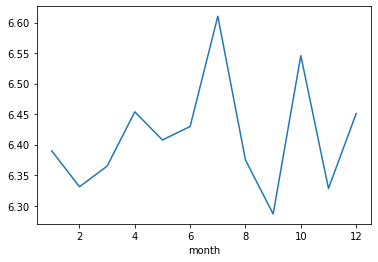

In [69]:
clean_data.groupby("month")["rating"].mean().plot()

This looks like there's seasonality in ratings. However, there might just be seasonality in something else that's correlated with ratings (eg. more or less releases)

In [74]:
clean_data = clean_data.merge(clean_movies[["first_review", "tconst"]], how="left", on="tconst")

In [88]:
clean_movies["first_review_month"] = clean_movies["first_review"].dt.month

<ipython-input-88-d5af6bec2e66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_movies["first_review_month"] = clean_movies["first_review"].dt.month


<AxesSubplot:xlabel='first_review_month'>

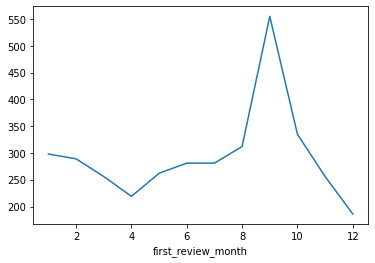

In [91]:
clean_movies.groupby("first_review_month")["averageReview"].count().plot()

Yikes, lower ratings when there's more new movies... that's not what I'd have thought

However, it's also sus that most movies come out in September... lines up with awards circuit because that's when people do their ratings

So we have an explanation! I bet critics are harsher than normal audiences

Uniform distribution across release days

Text(0.5, 0, 'Day of Month of Estimated Release Date')

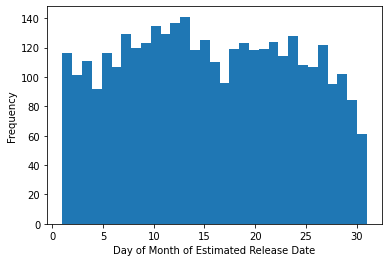

In [327]:
ax = clean_movies["first_review"].dt.day.plot(kind="hist",bins=31, xlabel="day of month")
ax.set_xlabel("Day of Month of Estimated Release Date")

<AxesSubplot:ylabel='Frequency'>

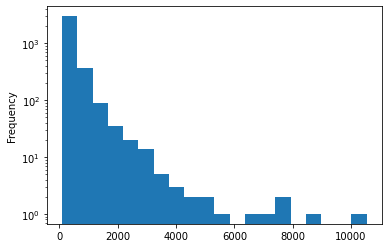

In [99]:
clean_movies["numReviews"].plot(kind="hist", logy=True, bins=20)

In [100]:
clean_movies[clean_movies["numReviews"] > 1000]

,averageReview,primaryTitle,startYear,genres,runtimeMinutes,numReviews,tconst,averageRating,numVotes,diffRating,ratioVotes,first_review,first_review_month
45005,7.209377,Star Wars: Episode III - Revenge of the Sith,2005,"Action,Adventure,Fantasy",140,3434,tt0121766,7.5,742810,0.290623,216.310425,2005-05-04,5
55238,6.838735,Children of Men,2006,"Action,Drama,Sci-Fi",109,1296,tt0206634,7.9,482291,1.061265,372.138117,2006-09-02,9
65918,7.115668,Harry Potter and the Goblet of Fire,2005,"Adventure,Family,Fantasy",157,1902,tt0330373,7.7,579708,0.584332,304.788644,2005-11-05,11
67033,6.542918,Superman Returns,2006,"Action,Sci-Fi",154,2330,tt0348150,6.0,277055,-0.542918,118.907725,2006-06-18,6
67797,6.623314,Constantine,2005,"Action,Fantasy,Horror",121,1038,tt0360486,7.0,324636,0.376686,312.751445,2005-02-01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134254,5.911073,Extraction,2020,"Action,Thriller",116,2935,tt8936646,6.7,182618,0.788927,62.220784,2020-04-24,4
134278,7.386401,Knives Out,2019,"Comedy,Crime,Drama",130,2412,tt8946378,7.9,548517,0.513599,227.411692,2019-10-09,10
135050,6.829565,El Camino: A Breaking Bad Movie,2019,"Action,Crime,Drama",122,1725,tt9243946,7.3,209060,0.470435,121.194203,2019-10-11,10
135703,4.726852,Chhapaak,2020,"Biography,Drama",120,1296,tt9614460,5.1,26300,0.373148,20.293210,2020-01-10,1


<AxesSubplot:xlabel='first_review'>

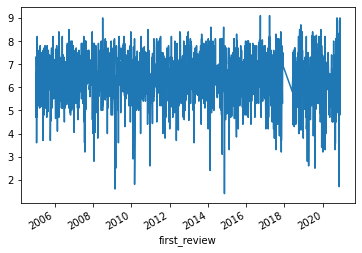

In [103]:
clean_movies.groupby("first_review")["averageRating"].mean().plot()

What's the distribution of ratings?

<AxesSubplot:ylabel='Frequency'>

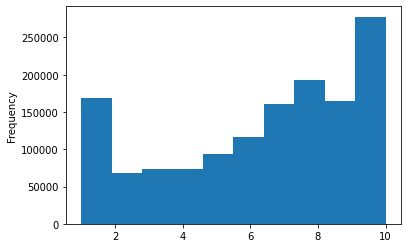

In [115]:
clean_data["rating"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

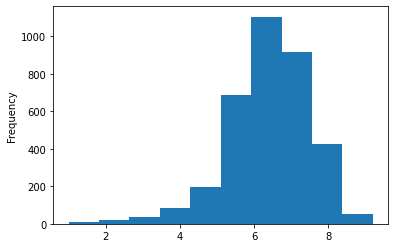

In [120]:
clean_movies["averageRating"].plot(kind="hist", bins=10)

<AxesSubplot:ylabel='Frequency'>

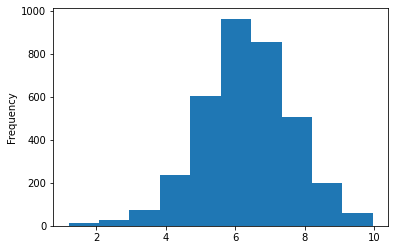

In [119]:
clean_movies["averageReview"].plot(kind="hist", bins=10)

In [107]:
clean_data["year_month"] = 100*clean_data["date"].dt.year + clean_data["date"].dt.month

In [105]:
clean_data["first_review_year_month"] = 100*clean_data["first_review"].dt.year + clean_data["first_review"].dt.month

In [110]:
clean_data["first_review_year"] = clean_data["first_review"].dt.year

In [112]:
clean_data["first_review_month_offset"] = (clean_data["year"] - clean_data["first_review_year"])*12 + clean_data["month"] - clean_data["first_review_month"]

In [121]:
clean_data.head()

,user,movie,rating,date,userdate,year,month,tconst,titleType,primaryTitle,...,startYear,endYear,runtimeMinutes,genres,first_review,first_review_month,first_review_year_month,year_month,first_review_year,first_review_month_offset
0,ur1529007,tt0357277,3,2005-01-16,ur152900716 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0
1,ur2705247,tt0357277,10,2005-01-16,ur270524716 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0
2,ur1976369,tt0357277,5,2005-01-16,ur197636916 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0
3,ur3198732,tt0357277,10,2005-01-16,ur319873216 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0
4,ur4571533,tt0357277,10,2005-01-16,ur457153316 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0


Are there more ratings overall in May 2018?

<AxesSubplot:xlabel='date'>

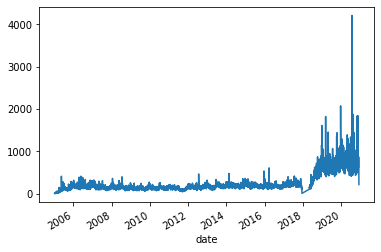

In [133]:
clean_data.groupby("date")["rating"].count().plot()

In [137]:
clean_data.head()

,user,movie,rating,date,userdate,year,month,tconst,titleType,primaryTitle,...,startYear,endYear,runtimeMinutes,genres,first_review,first_review_month,first_review_year_month,year_month,first_review_year,first_review_month_offset
0,ur1529007,tt0357277,3,2005-01-16,ur152900716 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0
1,ur2705247,tt0357277,10,2005-01-16,ur270524716 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0
2,ur1976369,tt0357277,5,2005-01-16,ur197636916 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0
3,ur3198732,tt0357277,10,2005-01-16,ur319873216 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0
4,ur4571533,tt0357277,10,2005-01-16,ur457153316 January 2005,2005,1,tt0357277,movie,Elektra,...,2005,\N,97,"Action,Adventure,Crime",2005-01-12,1,200501,200501,2005,0


In [168]:
panel = clean_data.groupby(["movie", "first_review_month_offset"])[["runtimeMinutes", "rating", "month", "year", "year_month", "first_review_year", "first_review_month", "first_review_year_month"]].agg({"runtimeMinutes": "count", "rating": "sum", "month": "mean", "year": "mean", "year_month": "mean", "first_review_month": "mean", "first_review_year": "mean", "first_review_year_month": "mean"})

In [169]:
panel["cumulative_reviews"] = panel.groupby(level=0)["runtimeMinutes"].cumsum()

In [170]:
panel["cumsum_ratings"] = panel.groupby(level=0)["rating"].cumsum()

In [171]:
panel["cumavg_review"] = panel["cumsum_ratings"] / panel["cumulative_reviews"]

In [172]:
panel = panel.reset_index().rename(columns={"runtimeMinutes": "num_reviews", "rating": "sum_ratings"})

In [174]:
panel

,movie,first_review_month_offset,num_reviews,sum_ratings,month,year,year_month,first_review_month,first_review_year,first_review_year_month,cumulative_reviews,cumsum_ratings,cumavg_review
0,tt0120667,0,8,60,6,2005,200506,6,2005,200506,8,60,7.500000
1,tt0120667,1,507,3315,7,2005,200507,6,2005,200506,515,3375,6.553398
2,tt0120667,2,76,444,8,2005,200508,6,2005,200506,591,3819,6.461929
3,tt0120667,3,16,92,9,2005,200509,6,2005,200506,607,3911,6.443163
4,tt0120667,4,16,91,10,2005,200510,6,2005,200506,623,4002,6.423756
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176511,tt9900782,9,2,17,7,2020,202007,10,2019,201910,180,1620,9.000000
176512,tt9900782,10,6,52,8,2020,202008,10,2019,201910,186,1672,8.989247
176513,tt9900782,12,13,112,10,2020,202010,10,2019,201910,199,1784,8.964824
176514,tt9900782,13,8,57,11,2020,202011,10,2019,201910,207,1841,8.893720


In [175]:
panel["2018_or_later"] = (panel["year"] > 2018)

In [176]:
panel

,movie,first_review_month_offset,num_reviews,sum_ratings,month,year,year_month,first_review_month,first_review_year,first_review_year_month,cumulative_reviews,cumsum_ratings,cumavg_review,2018_or_later
0,tt0120667,0,8,60,6,2005,200506,6,2005,200506,8,60,7.500000,False
1,tt0120667,1,507,3315,7,2005,200507,6,2005,200506,515,3375,6.553398,False
2,tt0120667,2,76,444,8,2005,200508,6,2005,200506,591,3819,6.461929,False
3,tt0120667,3,16,92,9,2005,200509,6,2005,200506,607,3911,6.443163,False
4,tt0120667,4,16,91,10,2005,200510,6,2005,200506,623,4002,6.423756,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176511,tt9900782,9,2,17,7,2020,202007,10,2019,201910,180,1620,9.000000,True
176512,tt9900782,10,6,52,8,2020,202008,10,2019,201910,186,1672,8.989247,True
176513,tt9900782,12,13,112,10,2020,202010,10,2019,201910,199,1784,8.964824,True
176514,tt9900782,13,8,57,11,2020,202011,10,2019,201910,207,1841,8.893720,True


<AxesSubplot:ylabel='Frequency'>

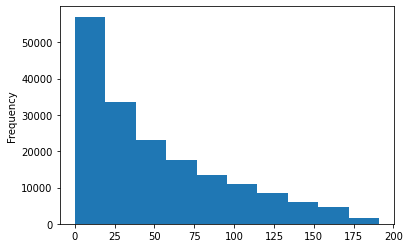

In [177]:
panel["first_review_month_offset"].plot(kind="hist")

In [319]:
panel["first_review_month_offset"].describe()

count    176516.000000
mean         50.814306
std          44.721076
min           0.000000
25%          14.000000
50%          37.000000
75%          78.000000
max         191.000000
Name: first_review_month_offset, dtype: float64

In [178]:
panel

,movie,first_review_month_offset,num_reviews,sum_ratings,month,year,year_month,first_review_month,first_review_year,first_review_year_month,cumulative_reviews,cumsum_ratings,cumavg_review,2018_or_later
0,tt0120667,0,8,60,6,2005,200506,6,2005,200506,8,60,7.500000,False
1,tt0120667,1,507,3315,7,2005,200507,6,2005,200506,515,3375,6.553398,False
2,tt0120667,2,76,444,8,2005,200508,6,2005,200506,591,3819,6.461929,False
3,tt0120667,3,16,92,9,2005,200509,6,2005,200506,607,3911,6.443163,False
4,tt0120667,4,16,91,10,2005,200510,6,2005,200506,623,4002,6.423756,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176511,tt9900782,9,2,17,7,2020,202007,10,2019,201910,180,1620,9.000000,True
176512,tt9900782,10,6,52,8,2020,202008,10,2019,201910,186,1672,8.989247,True
176513,tt9900782,12,13,112,10,2020,202010,10,2019,201910,199,1784,8.964824,True
176514,tt9900782,13,8,57,11,2020,202011,10,2019,201910,207,1841,8.893720,True


In [179]:
panel.to_csv("211215clean_movie_panel.csv")

Can we look at individual movies over time?

In [185]:
panel.columns

Index(['movie', 'first_review_month_offset', 'num_reviews', 'sum_ratings',
       'month', 'year', 'year_month', 'first_review_month',
       'first_review_year', 'first_review_year_month', 'cumulative_reviews',
       'cumsum_ratings', 'cumavg_review', '2018_or_later'],
      dtype='object')

In [292]:
curmovie = panel["movie"].sample().values[0]

<AxesSubplot:xlabel='first_review_month_offset'>

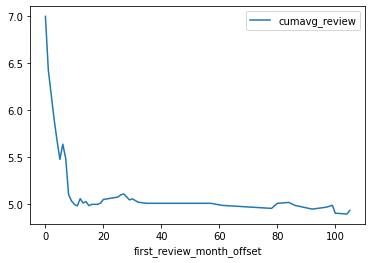

In [293]:
panel[panel["movie"] == curmovie].plot(x="first_review_month_offset", y="cumavg_review")

In [181]:
panel.set_index(["movie", "first_review_month_offset"]).unstack()

num_reviews                                          \
first_review_month_offset         0      1      2      3      4     5     6     
movie                                                                           
tt0120667                         8.0  507.0   76.0   16.0   16.0   7.0  46.0   
tt0121164                         1.0   90.0   98.0   27.0   12.0  10.0  24.0   
tt0121766                      1668.0  475.0   98.0   44.0   35.0  35.0  66.0   
tt0200465                         9.0   36.0   20.0    4.0    6.0  12.0  13.0   
tt0206634                        56.0   62.0   43.0   58.0  305.0  73.0  39.0   
...                               ...    ...    ...    ...    ...   ...   ...   
tt9866072                       100.0  195.0    5.0    NaN    NaN   NaN   NaN   
tt9866700                        12.0    2.0  117.0  199.0    NaN   1.0   NaN   
tt9877170                       102.0    3.0    1.0  103.0   22.0  14.0   6.0   
tt9898858                       326.0   29.0   11.0    9.0    4.0   2.0   2.0   
tt9900782                        67.0   52.0   17.0    7.0    4.0   3.0  11.0   

                                             ... 2018_or_later              \
first_review_month_offset   7     8     9    ...           182   183   184   
movie                                        ...                             
tt0120667                  22.0  14.0   9.0  ...          True  True   NaN   
tt0121164                  19.0  11.0  10.0  ...          True  True   NaN   
tt0121766                  44.0  43.0  22.0  ...          True  True  True   
tt0200465                   3.0   4.0   2.0  ...           NaN   NaN   NaN   
tt0206634                  55.0  41.0  27.0  ...           NaN   NaN   NaN   
...                         ...   ...   ...  ...           ...   ...   ...   
tt9866072                   NaN   NaN   NaN  ...           NaN   NaN   NaN   
tt9866700                   NaN   NaN   NaN  ...           NaN   NaN   NaN   
tt9877170                   3.0   2.0   8.0  ...           NaN   NaN   NaN   
tt9898858                   3.0   NaN   NaN  ...           NaN   NaN   NaN   
tt9900782                  14.0   3.0   2.0  ...           NaN   NaN   NaN   

                                                                
first_review_month_offset   185   186  187  188  189  190  191  
movie                                                           
tt0120667                  True   NaN  NaN  NaN  NaN  NaN  NaN  
tt0121164                   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
tt0121766                  True  True  NaN  NaN  NaN  NaN  NaN  
tt0200465                   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
tt0206634                   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
...                         ...   ...  ...  ...  ...  ...  ...  
tt9866072                   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
tt9866700                   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
tt9877170                   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
tt9898858                   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
tt9900782                   NaN   NaN  NaN  NaN  NaN  NaN  NaN  

[3530 rows x 2304 columns]

In [ ]:
panel.loc[1]

Is there seasonality in reviews if we control for month of release? Want to compare average reviews by month of observation among this subset

<AxesSubplot:xlabel='month'>

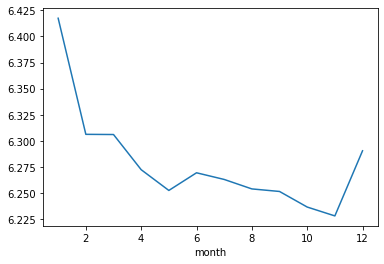

In [299]:
panel[panel["first_review_month"] == 1].groupby("month")["cumavg_review"].mean().plot()

<AxesSubplot:xlabel='month'>

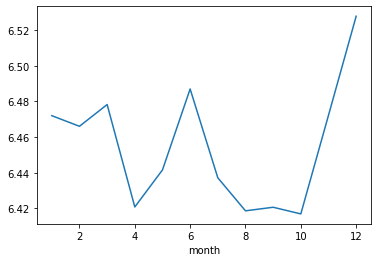

In [310]:
panel[panel["first_review_month"] == 12].groupby("month")["cumavg_review"].mean().plot()

So there's some seasonality, but it makes our coefficients hard to interpret (actually it doesn't really)

Seems like no, drop after January can be explained by delay from release. Not sure why there's a bump in December though - oops this is a histogram. Bump is because more ppl rate movies in December and Jan.

<AxesSubplot:>

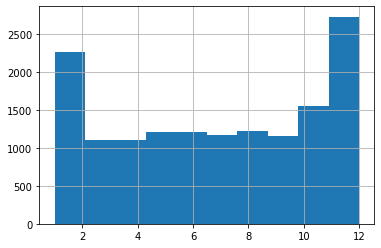

In [318]:
panel[panel["first_review_month"] == 10]["month"].hist()

In [294]:
panel

,movie,first_review_month_offset,num_reviews,sum_ratings,month,year,year_month,first_review_month,first_review_year,first_review_year_month,cumulative_reviews,cumsum_ratings,cumavg_review,2018_or_later
0,tt0120667,0,8,60,6,2005,200506,6,2005,200506,8,60,7.500000,False
1,tt0120667,1,507,3315,7,2005,200507,6,2005,200506,515,3375,6.553398,False
2,tt0120667,2,76,444,8,2005,200508,6,2005,200506,591,3819,6.461929,False
3,tt0120667,3,16,92,9,2005,200509,6,2005,200506,607,3911,6.443163,False
4,tt0120667,4,16,91,10,2005,200510,6,2005,200506,623,4002,6.423756,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176511,tt9900782,9,2,17,7,2020,202007,10,2019,201910,180,1620,9.000000,True
176512,tt9900782,10,6,52,8,2020,202008,10,2019,201910,186,1672,8.989247,True
176513,tt9900782,12,13,112,10,2020,202010,10,2019,201910,199,1784,8.964824,True
176514,tt9900782,13,8,57,11,2020,202011,10,2019,201910,207,1841,8.893720,True


How are numbers of reviews distributed over the months following release? Way to check our assumption that first review is date of release

<AxesSubplot:xlabel='first_review_month_offset'>

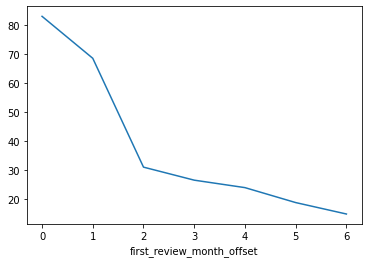

In [324]:
panel[panel["first_review_month_offset"] <= 6].groupby("first_review_month_offset")["num_reviews"].mean().plot()

So on average we're not doing too bad